# Zarr multi-scales with `pyramid_regrid`

This notebook demonstrates how to use `pyramid_regrid` to generate pyramids using `xesmf`'s Regridders.

In [1]:
import dask  # noqa
import xarray as xr

from ndpyramid.regrid import pyramid_regrid

## Setup output paths

You can set the output path to object storage or a memory store, after changing the S3 URI to a location that you have write access to. 


In [2]:
S3 = False
if S3:
    output = "s3://carbonplan-scratch/pyramid_comparison/regridded.zarr"
else:
    import zarr

    output = zarr.storage.MemoryStore()

## Open input dataset
 
In this example, we'll use some of CarbonPlan's [downscaled CMIP6 data](https://github.com/carbonplan/cmip6-downscaling) for the input dataset.

In [3]:
# Open the dataset
ds = xr.open_zarr(
    "https://rice1.osn.mghpcc.org/carbonplan/cp-cmip/version1/rechunked_data/GARD-SV/ScenarioMIP.CCCma.CanESM5.ssp245.r1i1p1f1.month.GARD-SV.tasmax.zarr",
    chunks={},
)
ds = ds.rio.write_crs("EPSG:4326")
ds

<xarray.Dataset> Size: 4GB
Dimensions:      (lat: 721, lon: 1440, time: 1020)
Coordinates:
  * lat          (lat) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * lon          (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time         (time) datetime64[ns] 8kB 2015-01-01 2015-02-01 ... 2099-12-01
    spatial_ref  int64 8B 0
Data variables:
    tasmax       (time, lat, lon) float32 4GB dask.array<chunksize=(780, 72, 144), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.8
    activity_id:                     ScenarioMIP
    cmip6_downscaling_contact:       hello@carbonplan.org
    cmip6_downscaling_explainer:     https://carbonplan.org/research/cmip6-do...
    cmip6_downscaling_institution:   CarbonPlan
    cmip6_downscaling_license:       CC-BY-4.0
    ...                              ...
    institution_id:                  CCCma
    member_id:                       r1i1p1f1
    references:                      Eyring, V., Bony, S., Meehl, G. A., Seni...
    source_id:                       CanESM5
    timescale:                       day
    variable_id:                     tasmax

## Generate pyramids

We'll use the `pyramid_regrid` function to generate a pyramid with two levels. We'll use the `bilinear` resampling algorithm for comparison with the other pyramid generation methods.

In [4]:
%%time
levels = 2
regridded_pyramid = pyramid_regrid(ds, levels=levels, method="bilinear")
regridded_pyramid.to_zarr(output, consolidated=True, mode="w")

/Users/nrhagen/miniforge3/envs/ndpyramid/lib/python3.12/site-packages/xarray/core/computation.py:447: PerformanceWarning: Regridding is increasing the number of chunks by a factor of 8.0, you might want to specify sizes in `output_chunks` in the regridder call. Default behaviour is to preserve the chunk sizes from the input (72, 144).
  result_vars[name] = func(*variable_args)


CPU times: user 4min 25s, sys: 1min 56s, total: 6min 22s
Wall time: 7min 5s


## Open and plot the result


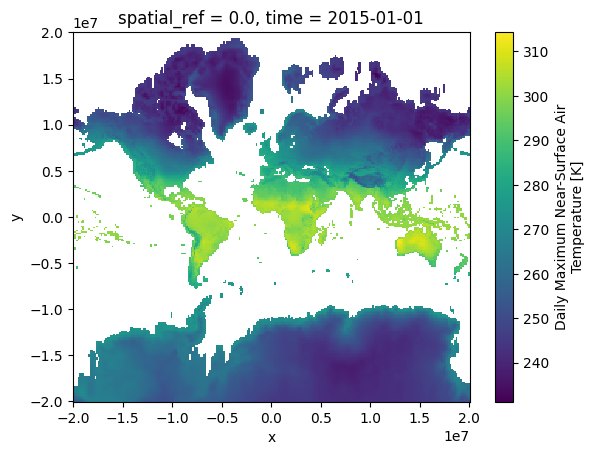

In [5]:
dt = xr.open_datatree(output, engine="zarr")
dt["1"].ds.isel(time=0).tasmax.plot()